<a href="https://colab.research.google.com/github/A01793146/demodatabricks/blob/main/Semana3_Algoritmos_Mejoramiento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3.2 Google Colab - Algoritmos de mejoramiento de imágenes en el dominio espacial

## Table of Contents
1. [Libraries](#libraries)
2. [Simple Example](#simple)
3. [PyTorch Convolution](#pytorch)
4. [Challenge](#challenge)

## Equipo 29

- Abraham Rincón Treviño - A00819677
- Juan Carlos García Rendón Martínez - A01793708
- Juan Carlos Garza Sánchez - A00821522
- Emmanuel González Calitl - A01320739
- Alejandro Jesús Vázquez Navarro - A01793146

## Importing Libraries <a class="anchor" id="libraries" ></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

## Simple Convolution <a class="anchor" id="simple" ></a>

### Definition

- __I__: Image to convolve.
- __H__: filter matrix to convolve the image with.
- __J__: Result of the convolution.

The following graphics shows exemplary the mathematical operations of the convolution. The filter matrix __H__ is shifted over the input image __I__. The values 'under' the filter matrix are multiplicated with the corresponding values in __H__, summed up and writen to the result __J__. The target position is usually the position under the center of __H__.

<img src="https://github.com/A01793146/demodatabricks/blob/main/data/convolution.png?raw=1" width="70%">

In order to implement the convolution with a block filter, we need two methods. The first one will create the block filter matrix __H__ depending on the filter width/height __n__.

A block filter holds the value $\dfrac{1}{n\cdot n}$ at each position:

In [2]:
def block_filter(n):
    H = np.ones((n, n)) / (n * n) # each element in H has the value 1/(n*n)
    return H

We will test the method by creating a filter with ``n = 5``:

In [3]:
H = block_filter(5)
print(H)

[[0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]]


Next, we define the actual convolution operation. To prevent invalid indices at the border of the image, we introduce the padding __p__.

In [4]:
def apply_filter(I, H):
    h, w = I.shape                         # image dimensions (height, width)
    n = H.shape[0]                         # filter size
    p = n // 2                             # padding size
    J = np.zeros_like(I)                   # output image, initialized with zeros

    for x in range(p, h-p):
        for y in range(p, w-p):
            J[x, y] = np.sum(I[x-p:x+n-p, y-p:y+n-p] * H)
    return J

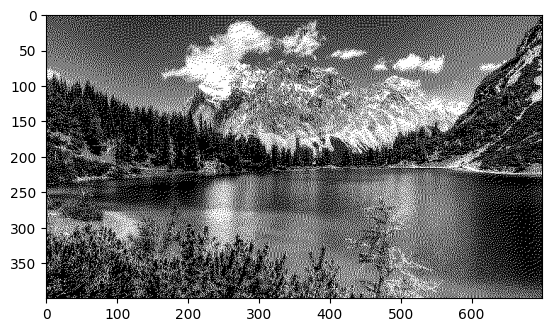

In [5]:
image = Image.open('data/image.jpg')
image = image.convert('1') # convert image to black and white

image = np.array(image)

# image = np.zeros((200, 200), dtype=np.float)
# for x in range(200):
#     for y in range(200):
#         d = ((x-100)**2+(y-100)**2)**0.5
#         image[x, y] = d % 8 < 4

plt.imshow(image, cmap='gray',vmin=0.0, vmax=1.0)
plt.show()

In [6]:
image = image.astype(float)

Next we test our implementation and apply a block filter with size 7

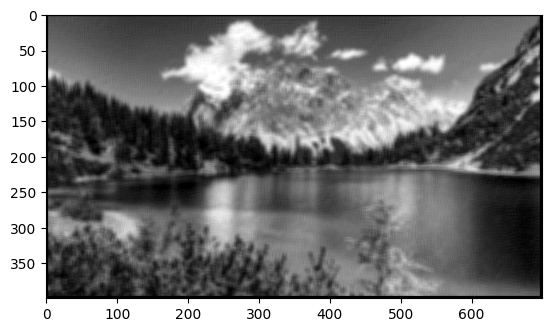

In [7]:
n = 7
H = block_filter(n)
J = apply_filter(image, H)

plt.imshow(J, cmap='gray')
plt.show()

## PyTorch Convolution <a class="anchor" id="pytorch" ></a>

In [8]:
from PIL import Image

img = Image.open('data/image.jpg')
img.thumbnail((256,256), Image.ANTIALIAS) # Resize to half to reduce the size of this notebook.

<ipython-input-8-7c8c44ebc1df>:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img.thumbnail((256,256), Image.ANTIALIAS) # Resize to half to reduce the size of this notebook.


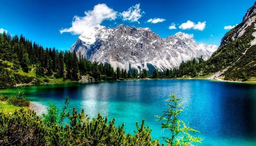

In [9]:
img

In [10]:
import torch, torchvision
from torchvision import transforms
from torch import nn

In [11]:
to_tensor = transforms.Compose([
   transforms.Grayscale(),  # Convert image to grayscale.
   transforms.ToTensor()    # Converts a PIL Image in the range [0, 255] to a torch.FloatTensor in the range [0.0, 1.0].
])

to_pil = transforms.Compose([
    transforms.ToPILImage()
])

In [12]:
input = to_tensor(img)
input.shape


torch.Size([1, 146, 256])

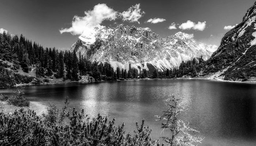

In [13]:
to_pil(input)

2D convolution over an input image:

+ `in_channels = 1`: an input is a grayscale image
+ `out_channels = 1`: an output is a grayscale image
+ `kernel_size = (3, 3)`: the kernel (filter) size is 3 x 3
+ `stride = 1`: the stride for the cross-correlation is 1
+ `padding = 1`: zero-paddings on both sides for 1 point for each dimension
+ `bias = False`: no bias parameter (for simplicity)

In [14]:
conv = nn.Conv2d(1, 1, (3, 3), stride=1, padding=1, bias=False)

In [15]:
# The code below does not work because the convolution layer requires the dimension for batch.
conv(input)

tensor([[[-0.0671,  0.0081,  0.0078,  ...,  0.0150, -0.0161, -0.0397],
         [-0.0687,  0.0268,  0.0235,  ...,  0.0120,  0.0132, -0.1023],
         [-0.0705,  0.0264,  0.0258,  ..., -0.0052,  0.0182, -0.0755],
         ...,
         [-0.0194,  0.0060, -0.0170,  ...,  0.0249,  0.0322, -0.1243],
         [-0.0107,  0.0090,  0.0010,  ...,  0.0250,  0.0343, -0.1333],
         [ 0.0181, -0.0101, -0.0466,  ..., -0.0351, -0.0228, -0.1310]]],
       grad_fn=<SqueezeBackward1>)

We need to insert a dimension for a batch at dim=0.

In [16]:
input = input.unsqueeze(0)
input.shape

torch.Size([1, 1, 146, 256])

In [17]:
output = conv(input)
output.shape

torch.Size([1, 1, 146, 256])

Setting `padding=1` in the convolution layer, we obtain an image of the same size.

In [18]:
output.shape

torch.Size([1, 1, 146, 256])

We need to remove the first dimension before converting to a PIL object.

In [19]:
output.data.squeeze(dim=0).shape

torch.Size([1, 146, 256])

Display the output from the convolution layer by converting `output` to a PIL object.

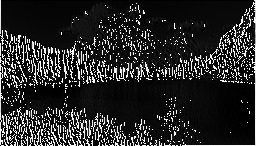

In [20]:
to_pil(output.data.squeeze(dim=0))

Clip every value in the output tensor within the range of [0, 1].

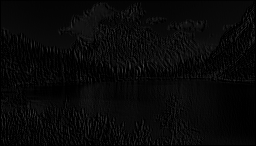

In [21]:
to_pil(torch.clamp(output, 0, 1).data.squeeze(dim=0))

In [22]:
def display(img1, img2):
    im1 = to_pil(torch.clamp(img1, 0, 1).data.squeeze(dim=0))
    im2 = to_pil(torch.clamp(img2, 0, 1).data.squeeze(dim=0))
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

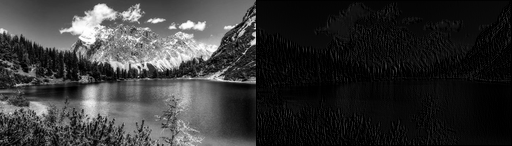

In [23]:
display(input, output)

### Identity

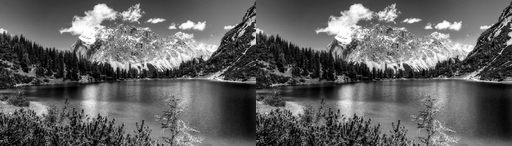

In [24]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 1, 0.],
    [0., 0., 0.],
]]])

output = conv(input)
display(input, output)

### Brighten

tensor([[[[0.0000, 0.0000, 0.0000],
          [0.0000, 1.5000, 0.0000],
          [0.0000, 0.0000, 0.0000]]]])


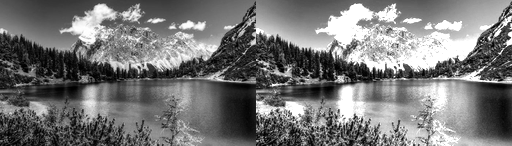

In [25]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 1.5, 0.],
    [0., 0., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### Darken

tensor([[[[0.0000, 0.0000, 0.0000],
          [0.0000, 0.5000, 0.0000],
          [0.0000, 0.0000, 0.0000]]]])


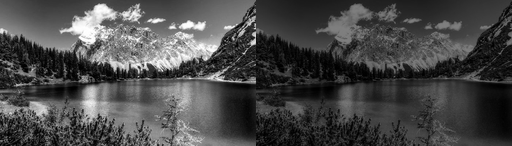

In [26]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 0.5, 0.],
    [0., 0., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### Box blur

tensor([[[[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]]]])


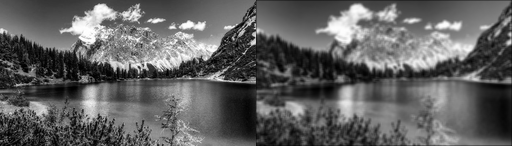

In [27]:
conv.weight.data = torch.ones((1, 1, 3,3), dtype=torch.float) / 9.
print(conv.weight.data)
output = conv(input)
display(input, output)

### Gaussian blur

tensor([[[[0.0625, 0.1250, 0.0625],
          [0.1250, 0.2500, 0.1250],
          [0.0625, 0.1250, 0.0625]]]])


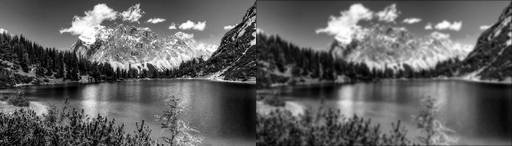

In [28]:
conv.weight.data = torch.tensor([[[
    [1., 2., 1.],
    [2., 4., 2.],
    [1., 2., 1.],
]]])/16.
print(conv.weight.data)
output = conv(input)
display(input, output)

### Sharpen

tensor([[[[ 0., -1.,  0.],
          [-1.,  5., -1.],
          [ 0., -1.,  0.]]]])


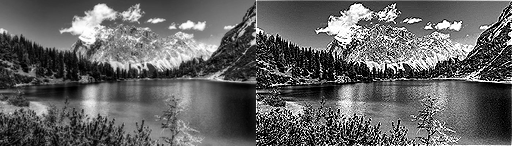

In [29]:
conv.weight.data = torch.tensor([[[
    [0., -1., 0.],
    [-1., 5., -1.],
    [0., -1., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

tensor([[[[ 0., -2.,  0.],
          [-2., 10., -2.],
          [ 0., -2.,  0.]]]])


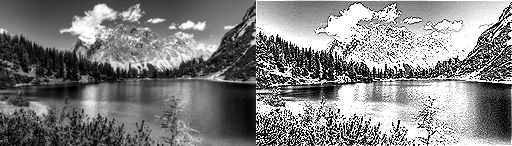

In [30]:
conv.weight.data = torch.tensor([[[
    [0., -2., 0.],
    [-2., 10., -2.],
    [0., -2., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### Edge detection

tensor([[[[ 0.,  1.,  0.],
          [ 1., -4.,  1.],
          [ 0.,  1.,  0.]]]])


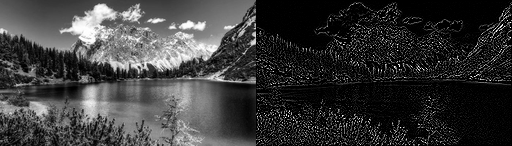

In [31]:
conv.weight.data = torch.tensor([[[
    [0., 1., 0.],
    [1., -4., 1.],
    [0., 1., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

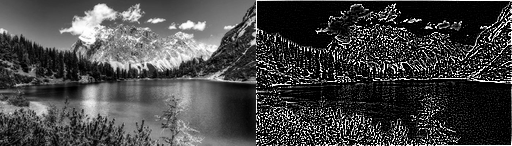

In [32]:
conv.weight.data = torch.tensor([[[
    [-1., -1., -1.],
    [-1., 8., -1.],
    [-1., -1., -1.],
]]])
output = conv(input)
display(input, output)

# Challenge

1. Implementa los detectores de línea siguientes usando código en Python (es decir, sin usar librerías de OpenCV): Prewitt, Sobel y Laplaciano. Investiga la complejidad algoritmica de estos, ¿cual es más eficiente?

In [33]:
# Carga de librerías

import numpy as np
import matplotlib.pyplot as plt
from skimage import color

from urllib.request import urlopen
from PIL import Image, ImageFilter
from io import BytesIO



1.a Prewitt

Reference: https://fiveko.com/prewitt-operator-for-edge-detection/


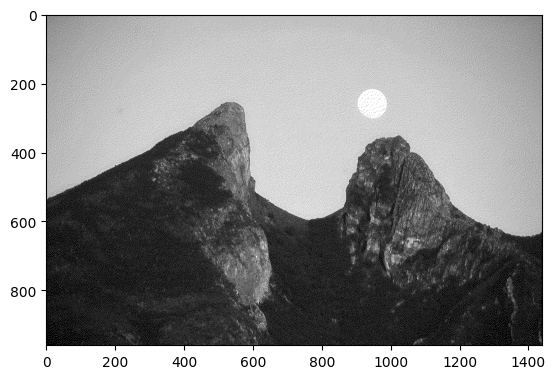

In [34]:
##Get Image:

#Function to get an image from internet:
def get_image_from_url(url):
    try:
        response = urlopen(url)
        image_data = response.read()
        image = Image.open(BytesIO(image_data))
        return image
    except Exception as e:
        print(f"Error: {e}")
        return None

image_url = "https://tipsparatuviaje.com/wp-content/uploads/2019/02/que-es-el-cerro-de-la-silla.jpg"

image =  get_image_from_url(image_url)
image = image.convert('1') # convert image to black and white

image = np.array(image)
plt.imshow(image, cmap='gray',vmin=0.0, vmax=1.0)
plt.show()

In [35]:

#Convolution function:

def apply_filter(I, H):
    h, w = I.shape                         # image dimensions (height, width)
    n = H.shape[0]                         # filter size
    p = n // 2                             # padding size
    J = np.zeros_like(I)                   # output image, initialized with zeros

    for x in range(p, h-p):
        for y in range(p, w-p):
            J[x, y] = np.sum(I[x-p:x+n-p, y-p:y+n-p] * H)
    return J

In [36]:

#Kernels:
Hx = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
Hy = np.array([[-1,-1,-1],[0,0,0],[1,1,1]])

#Apply filters in X and Y (convolation of kernel and Image):
Jx = apply_filter(image, Hx)
Jy = apply_filter(image, Hy)

print("Kernel to find edges in X direction:")
print(Hx)
print("\n Kernel to find edges in y direction:")
print(Hy)

Kernel to find edges in X direction:
[[-1  0  1]
 [-1  0  1]
 [-1  0  1]]

 Kernel to find edges in y direction:
[[-1 -1 -1]
 [ 0  0  0]
 [ 1  1  1]]


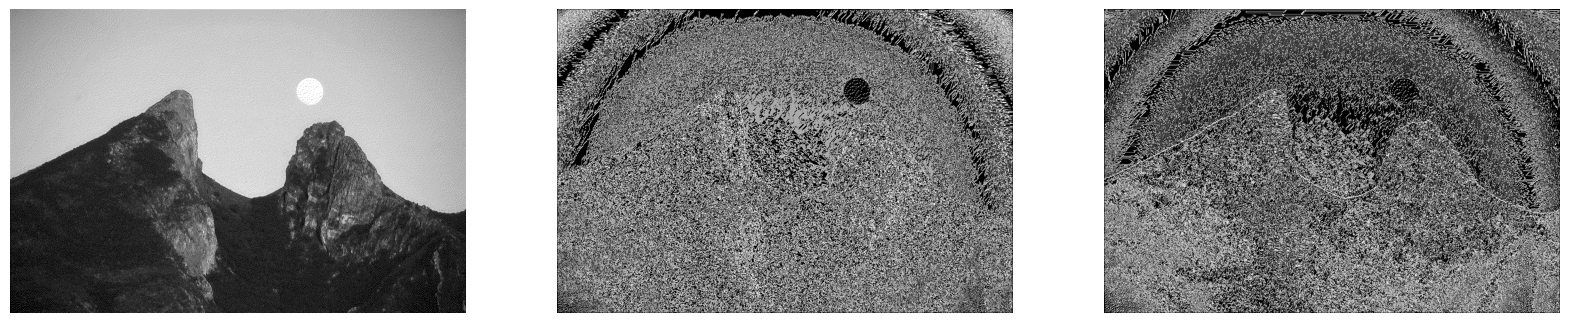

In [37]:

#Plotting images: Original
image = image.astype(float)
Images = np.array([image, Jx, Jy])
plt.figure(figsize = (20, 20))

for i in range(Images.shape[0]):
    plt.subplot(1, Images.shape[0], i + 1)
    plt.imshow(Images[i], cmap='gray')
    plt.axis('off')  # no axis

plt.show()

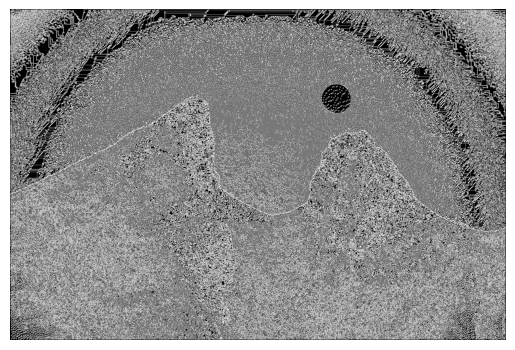

In [38]:

#Magnitude image:
edge_magnitude = np.sqrt(Jx**2 + Jy**2)

plt.imshow(edge_magnitude,cmap='gray')
plt.axis('off')  # no axis
plt.show()

1.b Sobel

Reference: https://fiveko.com/sobel-filter/



In [39]:
#Kernels:
Hx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
Hy = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])

#Apply filters in X and Y (convolation of kernel and Image):
Jx = apply_filter(image, Hx)
Jy = apply_filter(image, Hy)

print("Kernel to find edges in X direction:")
print(Hx)
print("\n Kernel to find edges in y direction:")
print(Hy)

Kernel to find edges in X direction:
[[ 1  0 -1]
 [ 2  0 -2]
 [ 1  0 -1]]

 Kernel to find edges in y direction:
[[ 1  2  1]
 [ 0  0  0]
 [-1 -2 -1]]


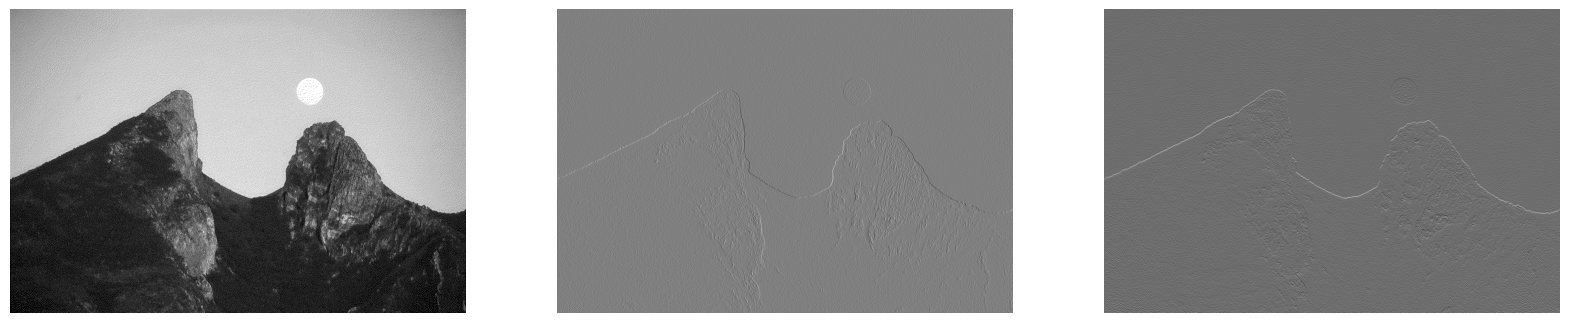

In [40]:
#Plotting images:
image = image.astype(float)
Images = np.array([image, Jx, Jy])
plt.figure(figsize = (20, 20))

for i in range(Images.shape[0]):
    plt.subplot(1, Images.shape[0], i + 1)
    plt.imshow(Images[i], cmap='gray')
    plt.axis('off')  # no axis

plt.show()

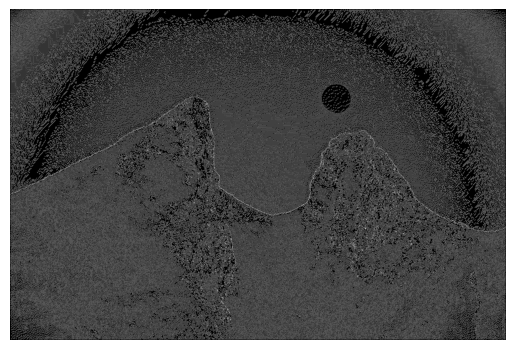

In [41]:
#Magnitude image:
edge_magnitude = np.sqrt(Jx**2 + Jy**2)

plt.imshow(edge_magnitude,cmap='gray')
plt.axis('off')  # no axis
plt.show()

1.c Laplaciano

In [42]:

# Definir kernel Laplaciano
kernel = np.array([[0, 1, 0],[1, -4, 1],[0, 1, 0]])
#kernel = np.array([[1, 1, 1],[1, -8, 1],[1, 1, 1]])

# Definir funcion de convolución
def convolucion(img, kernel):
  # Calcular largo y ancho
  h_img, w_img = img.shape
  h_ker, w_ker = kernel.shape

  # Calcular pixeles de padding necesarios
  h_pad = h_ker // 2
  w_pad = w_ker // 2

  # Agregar padding
  pad_img = np.pad(img, ((h_pad, h_pad), (w_pad, w_pad)))  #Por default los pads con 0

  # Definir imagen final
  final_img = np.zeros_like(img)

  # Iteramos y convolucionamos por cada pixel
  for h in range(h_img):
    for w in range(w_img):
      roi = pad_img[h:h+h_ker, w:w+w_ker]

      # Convolución
      final_img[h,w] = np.sum(roi * kernel)

  final_img = np.clip(final_img, 0, 255)
  return final_img

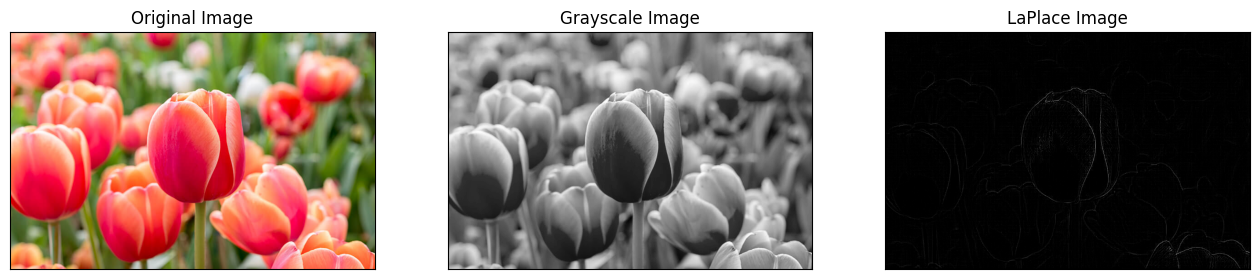

In [43]:
# Cargar imagen y convertir a grises
image_path = 'tulipan.jpg'
img = plt.imread(image_path)
gray_img = color.rgb2gray(img)

# Aplicar Kernel laplaciano
lp_image = convolucion(gray_img, kernel)

# Graficar imagenes
plt.figure(figsize=(16, 10))

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(gray_img, cmap='gray')
plt.title('Grayscale Image')

plt.subplot(1, 3, 3)
plt.imshow(lp_image, cmap='gray')
plt.title('LaPlace Image')

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.show()

1. d Investiga la complejidad algoritmica de estos ¿Cuál es más eficiente?

Antes de contestar la pregunta, es necesario visitar de manera sencilla lo que significa la complejidad algorítmica. Estamos hablando de una métrica meramente teórica que permite entender cómo se comporta un algoritmo en función del tiempo de ejecución y memoria para completar una tarea determinada. Con estos dos parámetros podemos entender qué algoritmos tienen mejor efectividad.

El algoritmo Laplaciano ofrece una complejidad **O(n)** donde n es el número de pixeles de la imagen. Cuando hablamos de los algoritmos Prewitt y Sobel podemos decir que tienen una complejidad **O(n^2)**.

Luego entonces si revisamos el funcionamiento del Laplaciano es fácil identificar que su eficiencia radica en que solo calcula la diferencia de los valores de los pixeles adyacentes (mediante el cálculo de la segunda derivada). No así con Prewitt y Sobel que calculan pendientes de los bordes. Ahora bien, el algoritmo Laplaciano tiene una mejor detección de bordes curvos y no es tan eficaz cuando existen bordes rectos. Esto hay que considerarlo en la elección del algoritmo.



2. Implementa un algoritmos de realce o mejoramiento de imágenes mediante un algoritmo de en el cual se extraen las líneas de la imagen y después se aplica la diferencia con la imagen original, multiplicando los píxeles de la imagen “máscara” (las líneas encontradas) por un factor alfa mayor a 1.

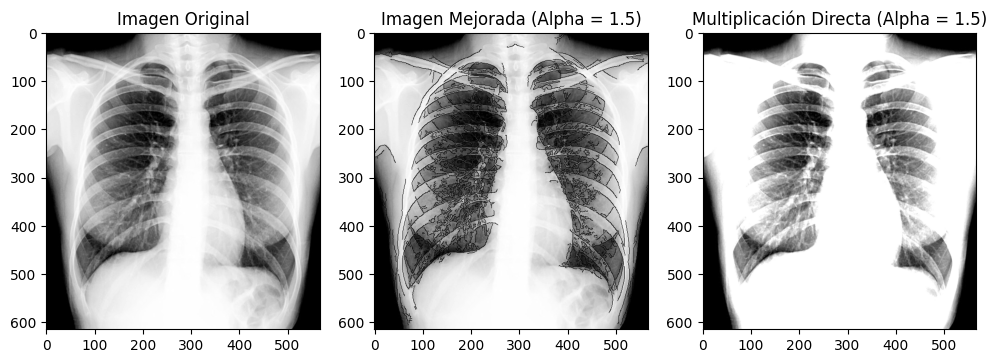

In [44]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def enhance_image_with_lines(image_path, alpha):
    # Cargar la imagen en escala de grises
    original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Aplicar un filtro de detección de bordes para extraer las líneas
    edges = cv2.Canny(original_image, 50, 150, apertureSize=3)

    # Crear una imagen de "máscara" con las líneas encontradas
    lines_mask = np.zeros_like(original_image)
    lines_mask[edges > 0] = 255

    # Multiplicar los píxeles de la máscara por un factor alfa mayor a 1
    enhanced_lines = cv2.multiply(lines_mask, alpha)

    # Calcular la diferencia entre la imagen original y la imagen mejorada con líneas
    enhanced_image = cv2.subtract(original_image, enhanced_lines)

    # Normalizar los valores de píxeles para que estén en el rango [0, 255]
    enhanced_image = cv2.normalize(enhanced_image, None, 0, 255, cv2.NORM_MINMAX)

    return original_image, enhanced_image

# Ruta de la imagen de entrada (asegúrate de subir tu imagen a Google Colab)
image_path = 'imagen.jpeg'

# Factor alfa mayor a 1 para el realce
alpha = 1.5

# Aplicar el realce de imagen con líneas
original, enhanced = enhance_image_with_lines(image_path, alpha)

# Mostrar las imágenes original y mejorada con líneas
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(original, cmap='gray')
plt.title('Imagen Original')

plt.subplot(1, 3, 2)
plt.imshow(enhanced, cmap='gray')
plt.title(f'Imagen Mejorada (Alpha = {alpha})')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(cv2.multiply(original, alpha), cv2.COLOR_BGR2RGB))
plt.title('Multiplicación Directa (Alpha = 1.5)')

plt.show()


3. Buscar una aplicación médica (en el libro de Gonzalez viene varios ejemplos de imágenes PET) y hacer mejoramiento usando la técnica de de la Figura 3.43 combinando diferentes etapas de procesamiento de imagenes

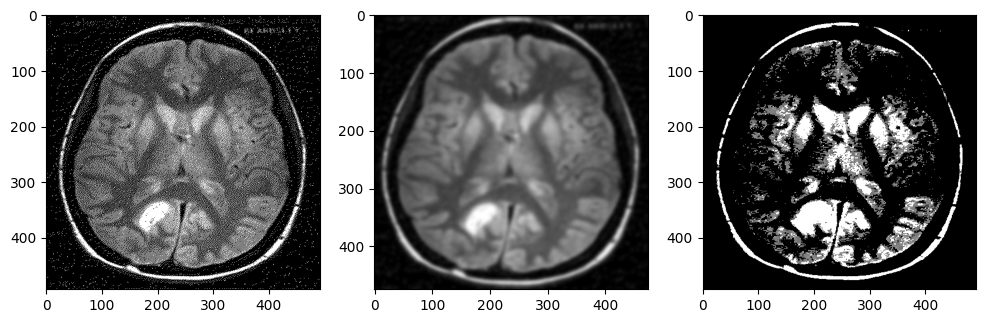

In [45]:
def convolution2d(img, kernel):
  kernel_height, kernel_width = kernel.shape
  height, width = img.shape
  new_height = height - kernel_height + 1
  new_width = width - kernel_width + 1
  new_image = np.zeros((new_height, new_width))
  for y in range(new_height):
      for x in range(new_width):
          new_image[y][x] = np.sum(img[y:y+kernel_height, x:x+kernel_width]*kernel)
  return new_image

def gaussian_kernel(size, std):
  kernel = np.empty((size, size), dtype=float)
  constant = (2 * np.pi * std**2)
  center = (size + 1) // 2
  for y in range(1, size + 1):
    for x in range(1, size + 1):
      delta_x = x - center
      delta_y = y - center
      ex = (-(delta_x**2 + delta_y**2) / (2 * std**2))
      value = np.exp(ex) / constant
      kernel[y - 1, x - 1] = value
  return kernel

def gaussian_lowpass(img, size, std):
  kernel = gaussian_kernel(size, std)
  return convolution2d(img, kernel)

def median_filter(img, size):
  height, width = img.shape
  kernel_center = size // 2
  copy = np.pad(img, (kernel_center, kernel_center), mode='edge')
  new_img = np.zeros(copy.shape, dtype=float)

  for y in range(kernel_center, height + kernel_center):
    for x in range(kernel_center,  width + kernel_center):
      new_img[y, x] = np.median(copy[y - kernel_center: y + kernel_center + 1, x - kernel_center: x + kernel_center + 1])
  return new_img[kernel_center: height + kernel_center, kernel_center: width + kernel_center]

image = Image.open('pet_salt_pepper.png')
image = image.convert('1')
image = np.array(image)

gauss_img = gaussian_lowpass(image, 19, 3)
med_img = median_filter(image, 3)
_, axs = plt.subplots(1, 3, figsize=(12, 12))

axs = axs.flatten()
axs[0].imshow(image, cmap='gray')
axs[1].imshow(gauss_img, cmap='gray')
axs[2].imshow(med_img, cmap='gray')
plt.show()
